## INSTALLATION


conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia  
conda install seaborn  
conda install -c conda-forge scikit-learn  
pip install tifffile  
conda install -c conda-forge notebook  
pip install imagecodecs

In [18]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 975.6 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 74.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.6/447.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 7.9 MB/s eta 0:00:00


## IMPORT

In [1]:
import os
import re
import numpy as np
from types import NoneType
from collections import OrderedDict
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data 
from torchvision import transforms, datasets, models
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import tifffile 
import matplotlib.pyplot as plt

In [2]:
#Setting GPU acceleration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Preprocessing

In [3]:


params = {'TARGET_DIR' : '/storage/group/tvq5043/default/Shiqi/New_Training_Data',
    'PATTERN' : r'5m',
    'HEIGTH' : 10,
    'WIDTH' : 10,
    'BANDS' : 48,
          #the size of the batch for the neural network
    'batch_size' : 5
    }
#path to the folder for create the augmented dataset
dest='./dataset'

In [4]:
#name_dict allows species merging (Key:Value pair where key is Original Specie and pair the new specie) 

name_dict={'Quercus rubra':'Quercus','Quercus alba':'Quercus','Acer rubrum':'Acer', 
           'Carya glabra':'Carya','Pinus strobus':'Pinus', 'Tsuga canadensis':'Tsuga',
           'Acer saccharum':'Acer','Quercus montana':'Quercus', 'Carya tormentosa': 'Carya',
           'Quercus velutina':'Quercus', 'Pinus virginiana':'Pinus', 'Carya ovata':'Carya',
            'Carya spp.':'Carya','Quercus velatina':'Quercus','Quercus coccinea':'Quercus',
           'Acer pennsylvanicum':'Acer', 'Pinus pungens':'Pinus'}
           

list_of_tree = list(set(name_dict.values()))

In [5]:
# Search in the target directory and all subdirectories for files that matches the pattern

#create a list of tree with all the paths to the images
tree_counts = {
    "Acer" : 0,
    "Carya" : 0,
    "Pinus" : 0,
    "Quercus" : 0,
    "Tsuga" : 0,
    None : 0
}
for dir_, _, filenames in os.walk(params['TARGET_DIR']):
    for filename in filenames:
        name=filename.split('/')[-1].split('_')[0]
        name =name_dict.get(name)
        tree_counts[name] = tree_counts[name] + 1

In [6]:
tree_counts

{'Acer': 105,
 'Carya': 112,
 'Pinus': 73,
 'Quercus': 264,
 'Tsuga': 42,
 None: 223}

In [7]:
list_of_image=[]

for dir_, _, filenames in os.walk(params['TARGET_DIR']):
    for filename in filenames:
        name=filename.split('/')[-1].split('_')[0]
        name =name_dict.get(name)
        repeat = 1
        if name == "Acer" or name == "Carya":
            repeat *= 2
        elif name == "Pinus":
            repeat *= 3
        elif name == "Tsuga":
            repeat *= 6
    
        if re.search(params['PATTERN'], filename) and name in list_of_tree:
        
            abspath = os.path.join(dir_, filename)
            for i in range(repeat):
                list_of_image.append(abspath)
        else:
            pass

In [8]:
len(list_of_image)

1169

In [28]:
from scipy.ndimage import rotate

arr = tifffile.imread(list_of_image[0]) 
rotated = rotate(arr, angle=5)
rotated

array([[[   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ]],

       [[   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [ 326.65244,  326.52814,  331.4819 , ..., 5918.7954 ,
         6039.567  , 6054.9355 ],
        [ 274.7846 ,  281.78635,  302.73212, ..., 6282.791  ,
         6453.418  , 6476.097  ],
        ...,
        [ 128.3568 ,  140.26053,  164.63579, ..., 3423.2078 ,
         3580.7195 , 3601.7073 ],
        [ 15

In [9]:
#  data augmentation (3 rotation, 1flip followed by 3rotation) 
# dest folder to save images

Path(dest).mkdir(parents=True, exist_ok=True)

list_aug=[]
for im in list_of_image:
    arr = tifffile.imread(im) 
    arr = np.rot90(arr, k=1, axes=(0, 1))
    name = im.split('/')[-1]+ '_' + 'rot90'
    tifffile.imwrite(os.path.join(dest,name), arr)
    list_aug.append(os.path.join(dest,name))
    
    arr = tifffile.imread(im) 
    arr = np.rot90(arr, k=2, axes=(0, 1))
    name = im.split('/')[-1] +'_' + 'rot180'
    tifffile.imwrite(os.path.join(dest,name), arr)
    list_aug.append(os.path.join(dest,name))

    arr = tifffile.imread(im) 
    arr = np.rot90(arr, k=3, axes=(0, 1))
    name = im.split('/')[-1] +'_' + 'rot270'
    tifffile.imwrite(os.path.join(dest,name), arr)
    list_aug.append(os.path.join(dest,name))

    arr = tifffile.imread(im)
    arr = np .flip (arr, axis=0)
    name = im.split('/')[-1]+ '_' + 'flip'
    tifffile.imwrite(os.path.join(dest,name), arr)
    list_aug.append(os.path.join(dest,name))

    arr = tifffile.imread(im)
    arr = np .flip (arr, axis=0)
    arr = np.rot90(arr, k=1, axes=(0, 1))
    name =  im.split('/')[-1]+ '_' + 'flip90'
    tifffile.imwrite(os.path.join(dest,name), arr)
    list_aug.append(os.path.join(dest,name))

    arr = tifffile.imread(im)
    arr = np .flip (arr, axis=0)
    arr = np.rot90(arr, k=2, axes=(0, 1))
    name = im.split('/')[-1] + '_' + 'flip180'
    tifffile.imwrite(os.path.join(dest,name), arr)
    list_aug.append(os.path.join(dest,name))

    arr = tifffile.imread(im)
    arr = np .flip (arr, axis=0)
    arr = np.rot90(arr, k=3, axes=(0, 1))
    name = im.split('/')[-1]+ '_' + 'flip270'
    tifffile.imwrite(os.path.join(dest,name), arr)
    list_aug.append(os.path.join(dest,name))

In [10]:
#list all tree species based on names, count the number of different species

tree_specie =set()

for im in list_of_image:
    specie = im.split('/')[-1].split('_')[0]
    specie =name_dict.get(specie)
    tree_specie.add(specie)

number_of_tree=len(tree_specie)

# assign a number to the different specie for the classification 

dict_tree={}
for index,tree in enumerate(list(tree_specie)):
    dict_tree[tree]=index 



In [11]:
#Normalization create a numpy array and get some statistics 
raw=[]
for im in list_of_image:
    arr = tifffile.imread(im)
    arr = arr [:,:,:]
    assert arr.shape == (params['HEIGTH'],params['WIDTH'],params['BANDS'])
           
    raw.append(arr)
image=np.ravel(raw).reshape(-1,params['HEIGTH'],params['WIDTH'],params['BANDS'])

mean, std = np.mean(image,axis=(0,1,2)), np.std(image,axis=(0,1,2))

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [12]:
# Create the datloader Subclass torch.utils.data.Dataset 
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_list , specie_dict ,  transform=None) -> None:
        
        # 3. Create class attributes
        self.targ_list = targ_list
        self.specie_dict = specie_dict
        
        self.transform = transform

    # 4. Make function to load images
    def load_image(self, index: int):
        "Opens an image via a path and returns it."
        image_path = self.targ_list[index]
        return tifffile.imread(image_path) [:,:,:]
        
    def get_label(self, index: int):
        name_dict={'Quercus rubra':'Quercus','Quercus alba':'Quercus','Acer rubrum':'Acer', 
           'Carya glabra':'Carya','Pinus strobus':'Pinus', 'Tsuga canadensis':'Tsuga',
           'Acer saccharum':'Acer','Quercus montana':'Quercus', 'Carya tormentosa': 'Carya',
           'Quercus velutina':'Quercus', 'Pinus virginiana':'Pinus', 'Carya ovata':'Carya',
            'Carya spp.':'Carya','Quercus velatina':'Quercus','Quercus coccinea':'Quercus',
           'Acer pennsylvanicum':'Acer', 'Pinus pungens':'Pinus'}

        name = self.targ_list[index]
        specie = name.split('/')[-1].split('_')[0]
        specie = name_dict.get(specie)
 #       return self.one_hot[self.specie_dict[specie]]
        return self.specie_dict[specie]
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.targ_list)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_idx = self.get_label(index)
     
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [13]:

# instantiate the dataloader with the images 
list_final = list_of_image  + list_aug
dataset=ImageFolderCustom(list_final,dict_tree,data_transforms)

# size of the validation dataset
TEST_SIZE = 0.1
SEED = 42

# generate list of labels for stratified train/test split
target_list=[]
for i in range(len(dataset)):
    target_list.append(dataset[i][1])
    



train_idx, validation_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=TEST_SIZE,
                                             random_state=SEED,
                                             shuffle=True,
                                             stratify=target_list)

# Subset dataset for train and val
train_dataset = Subset(dataset, train_idx)
validation_dataset = Subset(dataset, validation_idx)

# Dataloader for train and val
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=params['batch_size'], shuffle=False)



## Model

In [14]:
# definition of the model
    #nn.MaxPool3d(3, stride=1),

# Adjusted 3D CNN Architecture
m = nn.Sequential(
    # Block 1
    nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1),  # Increased filters
    nn.BatchNorm3d(16),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=2, stride=2, padding=0),  # Ensure dimensions remain positive
    
    # Block 2
    nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),  # Deeper filters
    nn.BatchNorm3d(32),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=2, stride=2, padding=0),
    
    # Block 3
    nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm3d(64),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=2, stride=1, padding=0),  # Adjust stride and kernel size to prevent collapse
    
    # Block 4 (optional for deeper network)
    nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm3d(128),
    nn.ReLU(),
    nn.AdaptiveAvgPool3d((1, 1, 1)),  # Ensure a fixed output size
    
    # Flatten and Fully Connected Layers
    nn.Flatten(),
    nn.Linear(128, 64),  # Reduced dimension for better generalization
    nn.ReLU(),
    nn.Dropout(0.1),  # Regularization
    nn.Linear(64, 5)  # Output layer with 5 classes
)

# example for propagating a tensor through the network
input = torch.randn(5, 48, 10, 10)
input=torch.unsqueeze(input,1)

output = m(input)
output.shape

torch.Size([5, 5])

In [15]:
# Vision Transformer Test
class PatchEmbedding3D(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Conv3d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )
    
    def forward(self, x):
        # Shape: [batch_size, embed_dim, depth//patch_size, height//patch_size, width//patch_size]
        x = self.projection(x)  # Project patches into embeddings
        x = x.flatten(2)        # Flatten spatial dimensions
        x = x.transpose(1, 2)   # Shape: [batch_size, num_patches, embed_dim]
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Self-attention block
        attn_out, _ = self.self_attn(x, x, x)  # Shape: [batch_size, num_patches, embed_dim]
        x = x + attn_out
        x = self.norm1(x)
        
        # Feed-forward block
        mlp_out = self.mlp(x)
        x = x + mlp_out
        x = self.norm2(x)
        return x

class VisionTransformer3D(nn.Module):
    def __init__(self, in_channels, num_classes, patch_size, embed_dim, depth, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding3D(in_channels, patch_size, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))  # Learnable [CLS] token
        self.positional_encoding = nn.Parameter(
            torch.zeros(1, 1 + (48 // patch_size) * (10 // patch_size) * (10 // patch_size), embed_dim)
        )
        self.encoder = nn.ModuleList(
            [TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)]
        )
        self.cls_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes),
        )

    def forward(self, x):
        x = self.patch_embed(x)  # Patch embedding
        batch_size, num_patches, _ = x.shape
        
        # Add [CLS] token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Shape: [batch_size, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # Shape: [batch_size, 1 + num_patches, embed_dim]
        
        # Add positional encoding
        x = x + self.positional_encoding[:, : x.size(1), :]
        
        # Pass through transformer encoder
        for layer in self.encoder:
            x = layer(x)
        
        # Classification head
        cls_output = x[:, 0]  # Take [CLS] token
        out = self.cls_head(cls_output)
        return out

# Example Usage
m = VisionTransformer3D(
    in_channels=1,  # Single channel for grayscale
    num_classes=5,  # Number of classes
    patch_size=4,   # Divide 3D volume into (4x4x4) patches
    embed_dim=128,  # Embedding dimension for each patch
    depth=6,        # Number of transformer layers
    num_heads=8,    # Number of attention heads
    mlp_dim=256,    # Dimension of MLP hidden layer
    dropout=0.1     # Dropout for regularization
)

# Test input
input = torch.randn(5, 1, 48, 10, 10)  # Batch of 5, single channel, depth=48, height=10, width=10
output = m(input)
print(output.shape)  # Output: [5, 5]


torch.Size([5, 5])


In [15]:
from transformers import ViTForImageClassification
m = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", attn_implementation="eager", torch_dtype=torch.float16)

# Test input
input = torch.randn(5, 1, 48, 10, 10)  # Batch of 5, single channel, depth=48, height=10, width=10
output = m(input)
print(output.shape)  # Output: [5, 5]

/storage/group/tvq5043/default/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: too many values to unpack (expected 4)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# possible changes: change # heads to 6, change depth to ~4$

class PatchEmbedding3D(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size=(2, 4, 4)):
        super().__init__()
        self.proj = nn.Conv3d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        return self.proj(x)  # [batch_size, embed_dim, D_out, H_out, W_out]


class WindowAttention3D(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.window_size = window_size

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=True)
        self.softmax = nn.Softmax(dim=-1)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, D, H, W, C = x.shape
        x = x.view(B * D * H * W, C)  # Flatten spatial dimensions
        qkv = self.qkv(x).reshape(B * D * H * W, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(1, 2, 0, 3)

        attn = (q @ k.transpose(-2, -1)) / (C // self.num_heads) ** 0.5
        attn = self.softmax(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, D, H, W, C)
        x = self.proj(x.view(B * D * H * W, C)).view(B, D, H, W, C)
        return x


class SwinBlock3D(nn.Module):
    def __init__(self, embed_dim, window_size, num_heads):
        super().__init__()
        self.attn = WindowAttention3D(embed_dim, window_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = shortcut + x

        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = shortcut + x
        return x


class SwinTransformer3D(nn.Module):
    def __init__(self, in_channels, num_classes, embed_dim=96, window_size=(2, 7, 7), patch_size=(2, 4, 4), num_heads=4, depth=2):
        super().__init__()
        self.patch_embed = PatchEmbedding3D(in_channels, embed_dim, patch_size)
        self.layers = nn.ModuleList([
            SwinBlock3D(embed_dim, window_size, num_heads) for _ in range(depth)
        ])
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)  # [B, embed_dim, D, H, W]
        B, C, D, H, W = x.shape
        x = x.permute(0, 2, 3, 4, 1)  # [B, D, H, W, embed_dim]

        for layer in self.layers:
            x = layer(x)

        x = x.permute(0, 4, 1, 2, 3)  # [B, embed_dim, D, H, W]
        x = self.pool(x)
        x = x.view(B, -1)
        x = self.fc(x)
        return x


# Instantiate and test the model
m = SwinTransformer3D(
    in_channels=1,  # Single-channel input
    num_classes=5,  # Number of output classes
    embed_dim=96,   # Embedding dimension
    window_size=(2, 7, 7),
    patch_size=(2, 4, 4),
    num_heads=6,
    depth=4
)

# Test input
input_tensor = torch.randn(5, 1, 48, 10, 10)  # [batch_size, num_channels, depth, height, width]
output = model(input_tensor)
print(output.shape)  # Expected output: [5, num_classes]


torch.Size([5, 5])


In [ ]:
### TRAIN


In [ ]:
from torch import optim
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
optimizer = optim.Adam(m.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
m.to(device)
val_losses = []
train_losses = []
# train for a number of epochs
nbr_epochs=50

min_loss = 1e9
best_model = None

for epoch in range(nbr_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        inputs = torch.unsqueeze(inputs,1).to(device)
        # forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))                    
    running_loss = 0.0
                    
    running_loss = 0.0
    for i, data in enumerate(validation_loader, 0):
         inputs, labels = data
         labels.to(device)
         inputs = torch.unsqueeze(inputs,1).to(device)
         outputs = m(inputs)
         loss = criterion(outputs, labels.to(device))
         running_loss += loss.item()
    val_losses.append(running_loss/len(validation_loader))

    if running_loss/len(validation_loader) < min_loss:
        
        
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/len(validation_loader)}')
    running_loss = 0.0  
    
print('Finished Training')


[1,   188] loss: 1.491613084014426
[2,   188] loss: 1.4295181486200779
[3,   188] loss: 1.458761526866162
[4,   188] loss: 1.3924557791745409
[5,   188] loss: 1.3645539175956807
[6,   188] loss: 1.3339179953996172
[7,   188] loss: 1.3163807848666578
[8,   188] loss: 1.3757070144440264
[9,   188] loss: 1.2906375169119937
[10,   188] loss: 1.2264684790626486
[11,   188] loss: 1.2002068380726145
[12,   188] loss: 1.2013925176034583
[13,   188] loss: 1.119318500319694
[14,   188] loss: 1.1379796085839575
[15,   188] loss: 1.0861911477243646
[16,   188] loss: 0.9671336504373145
[17,   188] loss: 0.969893734030267
[18,   188] loss: 0.9290232336584557
[19,   188] loss: 0.825304666415174
[20,   188] loss: 0.7416854455987824
[21,   188] loss: 0.7679279837361042


In [29]:
train_losses

[0.08061397222877828]

In [30]:
val_losses

[1.3566383061309655,
 1.319440068056186,
 1.3038133184115093,
 1.3066272499660652,
 1.273679858694474,
 1.2616818255434434,
 1.2643747813999653,
 1.2549073131134112,
 1.2593605822573106,
 1.2019883841276169,
 1.2140434806545575,
 1.2174772936850786,
 1.229064888631304,
 1.1766055381546419,
 1.184870382770896,
 1.1877825533350308,
 1.1255945755789678,
 1.1458721179515123,
 1.1697895663479965,
 1.114672073473533,
 1.154428407549858,
 1.1392692690715194,
 1.171152471875151,
 1.1083666533231735,
 1.1249816079313557,
 1.178707802047332,
 1.148253496736288,
 1.0738498189797003,
 1.1527160772432883,
 1.2002685815095901,
 1.2118613243413467,
 1.1201910460367799,
 1.1369117684662342,
 1.1923769037239254,
 1.1649899625529845,
 1.0914796298990648,
 1.1744981951390703,
 1.0943538847689827,
 1.020733345920841,
 1.1012077789443235,
 1.169570092111826,
 1.001598668595155,
 1.1700271970282,
 1.1361860949546099,
 1.1265378817139815,
 1.030341441432635,
 1.1226954502053559,
 1.2110591509457056,
 1.07675

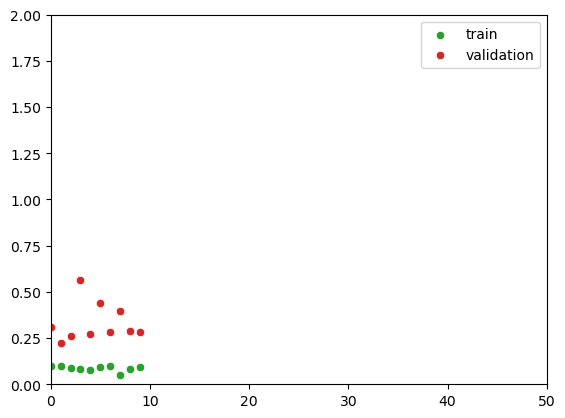

In [25]:
#plot training and validation loss as training go (both should go down and then plateau)
import seaborn as sns
fig, ax = plt.subplots()
sns.scatterplot(train_losses)
sns.scatterplot(val_losses)
ax.set_ylim(0, 2
           )
ax.set_xlim(0, 50)
sns.scatterplot(train_losses, label= 'train')
sns.scatterplot(val_losses,label='validation')
ax.legend()

188


/storage/group/tvq5043/default/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Axes: >

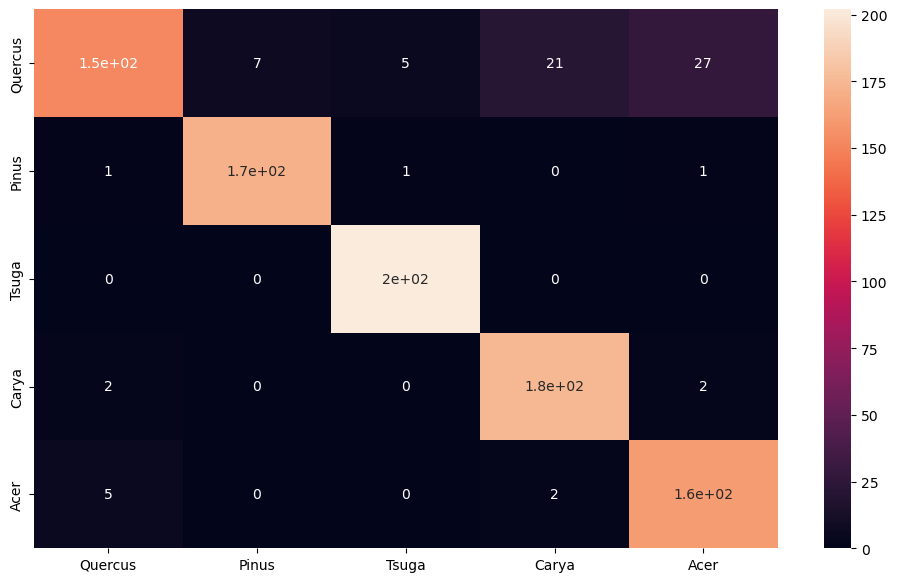

In [26]:
#plot the confusion matrix calculation on the validation set

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
print(len(validation_loader))
for inputs, labels in validation_loader:
        inputs = torch.unsqueeze(inputs,1).to(device)
        output = m(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        #output=output.data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

classes = list(dict_tree.keys())
from sklearn.metrics import confusion_matrix
# Build confusion matrix
cf_matrix = confusion_matrix(labels.astype(int), output.astype(int))
cf_matrix = confusion_matrix(np.array(y_true),np.array( y_pred))


cm = pd.DataFrame(cf_matrix, index = [i for i in classes],columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(cm, annot=True)
#plt.savefig('output.png')



In [27]:
from sklearn.metrics import classification_report
print(classification_report(np.array(y_true),np.array( y_pred), target_names=[i for i in classes], digits=3))

              precision    recall  f1-score   support

     Quercus      0.950     0.717     0.817       212
       Pinus      0.961     0.983     0.972       175
       Tsuga      0.971     1.000     0.985       202
       Carya      0.884     0.978     0.928       179
        Acer      0.843     0.958     0.897       168

    accuracy                          0.921       936
   macro avg      0.922     0.927     0.920       936
weighted avg      0.925     0.921     0.918       936

